In [65]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Make a list of files for easy iterating
# There are 5000 patient files
patient_files = glob.glob('training/*.psv')
len(patient_files)

5000

In [3]:
# Make the dictionary with first hour of diagnosis of sepsis as keys 
# and number of corresponding people as values 

# Also make a list of files of patients with and without Sepsis

first_hour, sepsis_files, no_sepsis_files = {}, [], []

first_hour['No Sepsis'] = 0
for file in patient_files:
    patient = pd.read_csv(file, sep='|')
    if 1 not in list(patient['SepsisLabel']):
        no_sepsis_files.append(file)
        first_hour['No Sepsis'] += 1
    else:
        sepsis_files.append(file)
        for idx, label in enumerate(patient['SepsisLabel']):
            if label == 1:
                hour = patient.loc[idx]['ICULOS'] 
                if hour not in first_hour:
                    first_hour[hour] = 0
                first_hour[hour] += 1
                break
first_hour

{'No Sepsis': 4721,
 1.0: 56,
 104.0: 2,
 180.0: 1,
 48.0: 2,
 34.0: 2,
 4.0: 5,
 27.0: 6,
 78.0: 2,
 90.0: 3,
 31.0: 1,
 154.0: 1,
 240.0: 1,
 122.0: 2,
 46.0: 2,
 91.0: 1,
 2.0: 6,
 158.0: 1,
 32.0: 4,
 20.0: 2,
 6.0: 5,
 55.0: 2,
 71.0: 2,
 57.0: 1,
 19.0: 4,
 3.0: 7,
 61.0: 3,
 14.0: 6,
 10.0: 1,
 139.0: 2,
 331.0: 1,
 7.0: 8,
 24.0: 5,
 108.0: 1,
 28.0: 3,
 121.0: 1,
 45.0: 3,
 16.0: 3,
 149.0: 1,
 54.0: 2,
 17.0: 2,
 84.0: 4,
 47.0: 3,
 30.0: 5,
 23.0: 4,
 33.0: 2,
 38.0: 2,
 198.0: 2,
 129.0: 1,
 5.0: 4,
 85.0: 1,
 9.0: 4,
 39.0: 3,
 83.0: 2,
 37.0: 2,
 135.0: 1,
 25.0: 2,
 36.0: 1,
 13.0: 5,
 60.0: 1,
 53.0: 2,
 35.0: 2,
 95.0: 1,
 68.0: 1,
 120.0: 1,
 181.0: 1,
 81.0: 2,
 40.0: 3,
 123.0: 2,
 243.0: 1,
 41.0: 1,
 21.0: 1,
 52.0: 2,
 29.0: 1,
 209.0: 1,
 62.0: 1,
 92.0: 2,
 63.0: 1,
 26.0: 3,
 75.0: 1,
 42.0: 1,
 155.0: 1,
 100.0: 1,
 156.0: 1,
 74.0: 1,
 79.0: 1,
 110.0: 2,
 251.0: 1,
 196.0: 1,
 12.0: 2,
 101.0: 1,
 69.0: 1,
 18.0: 2,
 93.0: 1,
 44.0: 1,
 224.0: 1,
 300.0: 1,

In [4]:
# Out of the 5000 patients, there are 279 cases where diagnosis of Sepsis was positive
len(sepsis_files)

279

In [5]:
# Create a new dictionary that further summarizes when the positive 
# patients get diagnosed within the first 20 hours, the next 20 hours, 
# and so on

new_first_hour = defaultdict(int)
for hour in list(first_hour.keys())[1:]:
    if hour <= 19:
        new_first_hour['0-20 Hours'] +=first_hour[hour]
        
    if hour >=20 and hour <= 39:
        new_first_hour['20-40 Hours'] +=first_hour[hour]
    
    if hour >=40 and hour <= 59:
        new_first_hour['40-60 Hours'] +=first_hour[hour]
    
    if hour >=60 and hour <= 79:
        new_first_hour['60-80 Hours'] +=first_hour[hour]
    
    if hour >=80 and hour <= 99:
        new_first_hour['80-100 Hours'] +=first_hour[hour]
    
    if hour >=100 and hour <= 119:
        new_first_hour['100-119 Hours'] +=first_hour[hour]
    
    if hour >=120 and hour <= 139:
        new_first_hour['120-140 Hours'] +=first_hour[hour]
    
    if hour >=140 and hour <= 159:
        new_first_hour['140-160 Hours'] +=first_hour[hour]
    
    if hour >=160 and hour <= 179:
        new_first_hour['160-180 Hours'] +=first_hour[hour]
    
    if hour >=180 and hour <= 199:
        new_first_hour['180-200 Hours'] +=first_hour[hour]
    
    if hour >=200:
        new_first_hour['200+ Hours'] +=first_hour[hour]
        
new_first_hour

defaultdict(int,
            {'0-20 Hours': 123,
             '100-119 Hours': 10,
             '180-200 Hours': 6,
             '40-60 Hours': 28,
             '20-40 Hours': 51,
             '60-80 Hours': 17,
             '80-100 Hours': 19,
             '140-160 Hours': 5,
             '200+ Hours': 10,
             '120-140 Hours': 10})

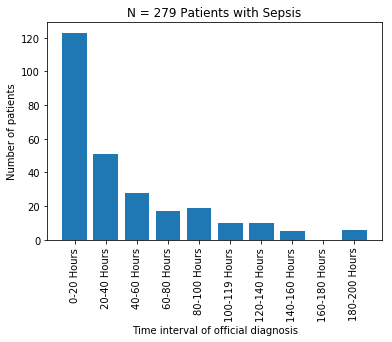

In [6]:
# Bar plot that shows how many hours after ICU admission do patients get official sepsis diagnosis

order = ['0-20 Hours', '20-40 Hours', '40-60 Hours', '60-80 Hours', '80-100 Hours',
        '100-119 Hours', '120-140 Hours', '140-160 Hours', '160-180 Hours', '180-200 Hours']
count = [new_first_hour[interval] for interval in order]

plt.bar(order,count)
plt.xticks(rotation=90)
plt.title('N = 279 Patients with Sepsis')
plt.xlabel('Time interval of official diagnosis')
plt.ylabel('Number of patients')
plt.show()

In [7]:
# EXAMPLE 
test = pd.read_csv(sepsis_files[20], sep='|')
test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,1,0
1,112.0,89.0,NaN,142.0,121.0,96.0,26.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,2,0
2,108.0,89.0,NaN,127.0,86.0,70.0,23.0,NaN,NaN,NaN,...,12.7,NaN,167.0,67,0,1,0,-0.12,3,0
3,106.0,89.5,NaN,107.5,89.5,73.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,4,0
4,105.0,85.0,NaN,117.5,92.0,75.0,33.5,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,5,0
5,116.0,85.0,NaN,99.0,88.0,76.0,32.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,6,1
6,106.0,86.0,NaN,111.0,60.0,45.0,36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,7,1
7,110.0,83.0,36.8,119.0,96.0,79.0,38.0,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,8,1
8,117.0,93.5,36.7,108.5,87.0,65.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,9,1
9,126.0,83.0,37.2,127.5,78.0,67.5,19.0,35.0,NaN,NaN,...,NaN,NaN,NaN,67,0,1,0,-0.12,10,1


In [8]:
test.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [9]:
# Ignore for now (trend features)

TS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
MV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

simple = test[TS_features]
simple['SepsisLabel'] = test['SepsisLabel']
simple

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,112.0,89.0,NaN,142.0,121.0,96.0,26.0,NaN,0
2,108.0,89.0,NaN,127.0,86.0,70.0,23.0,NaN,0
3,106.0,89.5,NaN,107.5,89.5,73.0,NaN,NaN,0
4,105.0,85.0,NaN,117.5,92.0,75.0,33.5,NaN,0
5,116.0,85.0,NaN,99.0,88.0,76.0,32.0,NaN,1
6,106.0,86.0,NaN,111.0,60.0,45.0,36.0,NaN,1
7,110.0,83.0,36.8,119.0,96.0,79.0,38.0,NaN,1
8,117.0,93.5,36.7,108.5,87.0,65.5,NaN,NaN,1
9,126.0,83.0,37.2,127.5,78.0,67.5,19.0,35.0,1


In [119]:
# Ignore for now (trend features)

for column in TS_features:
    simple[column].fillna((test[column].mean()), inplace=True)
    simple[str(column)+'_lag'] = simple[column].shift()
    simple[str(column)+'_rolling'] = simple[column].rolling(3).mean()
simple

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,SepsisLabel,HR_lag,...,SBP_lag,SBP_rolling,MAP_lag,MAP_rolling,DBP_lag,DBP_rolling,Resp_lag,Resp_rolling,EtCO2_lag,EtCO2_rolling
0,116.642857,89.642857,37.066667,112.071429,84.892857,68.821429,27.5,37.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,112.000000,89.000000,37.066667,142.000000,121.000000,96.000000,26.0,37.0,0,116.642857,...,112.071429,NaN,84.892857,NaN,68.821429,NaN,27.5,NaN,37.0,NaN
2,108.000000,89.000000,37.066667,127.000000,86.000000,70.000000,23.0,37.0,0,112.000000,...,142.000000,127.023810,121.000000,97.297619,96.000000,78.273810,26.0,25.500000,37.0,37.000000
3,106.000000,89.500000,37.066667,107.500000,89.500000,73.000000,27.5,37.0,0,108.000000,...,127.000000,125.500000,86.000000,98.833333,70.000000,79.666667,23.0,25.500000,37.0,37.000000
4,105.000000,85.000000,37.066667,117.500000,92.000000,75.000000,33.5,37.0,0,106.000000,...,107.500000,117.333333,89.500000,89.166667,73.000000,72.666667,27.5,28.000000,37.0,37.000000
5,116.000000,85.000000,37.066667,99.000000,88.000000,76.000000,32.0,37.0,1,105.000000,...,117.500000,108.000000,92.000000,89.833333,75.000000,74.666667,33.5,31.000000,37.0,37.000000
6,106.000000,86.000000,37.066667,111.000000,60.000000,45.000000,36.0,37.0,1,116.000000,...,99.000000,109.166667,88.000000,80.000000,76.000000,65.333333,32.0,33.833333,37.0,37.000000
7,110.000000,83.000000,36.800000,119.000000,96.000000,79.000000,38.0,37.0,1,106.000000,...,111.000000,109.666667,60.000000,81.333333,45.000000,66.666667,36.0,35.333333,37.0,37.000000
8,117.000000,93.500000,36.700000,108.500000,87.000000,65.500000,27.5,37.0,1,110.000000,...,119.000000,112.833333,96.000000,81.000000,79.000000,63.166667,38.0,33.833333,37.0,37.000000
9,126.000000,83.000000,37.200000,127.500000,78.000000,67.500000,19.0,35.0,1,117.000000,...,108.500000,118.333333,87.000000,87.000000,65.500000,70.666667,27.5,28.166667,37.0,36.333333


In [ ]:
# Ignore for now (Handling the missing data)

TS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
MV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

# TS features
for feature in TS_features:
    test[feature].fillna((test[feature].mean()), inplace=True)

# MV features
test[MV_features] = test[MV_features].fillna(method='ffill')
test[MV_features] = test[MV_features].fillna(method='bfill')

test.head()

In [10]:
# Prelim attempt to make a usable dataframe for ML #1
# Handling the missing data

VS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
LV_features = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']


prelim = []

# Create a numerical ID unique associated with each patient
for patientID, file in enumerate(patient_files):
    patient = pd.read_csv(file, sep='|')
    patient['ID'] = patientID
       
    for feature in VS_features:
        # Filling NaN values for VS features with mean
        patient[feature].fillna((patient[feature].mean()), inplace = True)
        
        # Filling NaN values for LV features with ffill/bfill
        patient[LV_features] = patient[LV_features].fillna(method='ffill')
        patient[LV_features] = patient[LV_features].fillna(method='bfill')
    # Create a column with binary outcome of patient, each patient has either all 0s (no sepsis), or 1s, (gets sepsis)
    if 1 not in list(patient['SepsisLabel']):
        patient['Gets_Sepsis'] = 0
    else:
        patient['Gets_Sepsis'] = 1 
    prelim.append(patient)

prelim_df = pd.concat(prelim, ignore_index=True)

In [12]:
# The remaining NaNs are only completely present on entire columns
prelim_df[prelim_df['ID']==3]

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
109,87.324324,95.277778,36.61,161.138889,97.614286,65.402778,18.033333,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,1,0,3,0
110,86.000000,95.000000,36.61,176.000000,100.000000,68.000000,16.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,2,0,3,0
111,82.000000,97.000000,36.00,174.000000,96.000000,66.000000,14.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,3,0,3,0
112,88.000000,96.000000,36.61,166.000000,100.000000,70.000000,15.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,4,0,3,0
113,90.000000,95.000000,36.61,174.000000,102.000000,70.000000,16.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,5,0,3,0
114,94.000000,97.000000,36.61,176.000000,98.000000,66.000000,17.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,6,0,3,0
115,90.000000,97.000000,35.90,166.000000,90.000000,60.000000,18.033333,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,7,0,3,0
116,86.000000,96.000000,36.61,160.000000,94.000000,64.000000,12.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,8,0,3,0
117,86.000000,95.000000,36.61,154.000000,92.000000,62.000000,13.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,9,0,3,0
118,84.000000,97.000000,36.61,146.000000,88.000000,60.000000,20.000000,NaN,NaN,NaN,...,162.0,63,1,NaN,NaN,-27.74,10,0,3,0


In [13]:
prelim_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'ID', 'Gets_Sepsis'],
      dtype='object')

In [14]:
prelim_df.shape

(188453, 43)

In [21]:
gets_sepsis = prelim_df[prelim_df['Gets_Sepsis']==1]
gets_sepsis.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
525,78.75,96.0,36.05,150.75,89.5,62.75,15.375,NaN,NaN,NaN,...,248.0,43,0,NaN,NaN,0.0,1,1,17,1
526,70.00,100.0,36.05,168.00,92.0,64.00,21.000,NaN,NaN,NaN,...,248.0,43,0,NaN,NaN,0.0,2,1,17,1
527,72.00,94.0,35.90,148.00,84.0,56.00,16.000,NaN,NaN,NaN,...,248.0,43,0,NaN,NaN,0.0,3,1,17,1
528,78.00,97.0,36.05,154.00,90.0,60.00,18.000,NaN,NaN,NaN,...,248.0,43,0,NaN,NaN,0.0,4,1,17,1
529,86.00,98.0,36.05,138.00,98.0,70.00,12.000,NaN,NaN,NaN,...,248.0,43,0,NaN,NaN,0.0,5,1,17,1


In [22]:
positiveIDs = pd.unique(list(gets_sepsis['ID']))
len(positiveIDs)

279

In [23]:
no_sepsis = prelim_df[prelim_df['Gets_Sepsis']==0]
negativeIDs = pd.unique(list(no_sepsis['ID']))
len(negativeIDs)

4721

In [24]:
prelim_df[prelim_df['ID']==positiveIDs[20]]

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
14467,116.642857,89.642857,37.066667,112.071429,84.892857,68.821429,27.5,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,1,0,387,1
14468,112.000000,89.000000,37.066667,142.000000,121.000000,96.000000,26.0,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,2,0,387,1
14469,108.000000,89.000000,37.066667,127.000000,86.000000,70.000000,23.0,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,3,0,387,1
14470,106.000000,89.500000,37.066667,107.500000,89.500000,73.000000,27.5,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,4,0,387,1
14471,105.000000,85.000000,37.066667,117.500000,92.000000,75.000000,33.5,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,5,0,387,1
14472,116.000000,85.000000,37.066667,99.000000,88.000000,76.000000,32.0,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,6,1,387,1
14473,106.000000,86.000000,37.066667,111.000000,60.000000,45.000000,36.0,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,7,1,387,1
14474,110.000000,83.000000,36.800000,119.000000,96.000000,79.000000,38.0,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,8,1,387,1
14475,117.000000,93.500000,36.700000,108.500000,87.000000,65.500000,27.5,37.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,9,1,387,1
14476,126.000000,83.000000,37.200000,127.500000,78.000000,67.500000,19.0,35.0,NaN,NaN,...,167.0,67,0,1.0,0.0,-0.12,10,1,387,1


In [25]:
# Let's consider only the Vital Signs, as defined below: 

vital_sign_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
                      'Age', 'Gender', 'SepsisLabel', 'ID', 'Gets_Sepsis']
prelim_vitals = prelim_df[vital_sign_columns]
prelim_vitals.describe()

# the EtCO2 feature has MANY MANY NaNs, while the other features barely have any 

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,SepsisLabel,ID,Gets_Sepsis
count,188439.000000,188453.000000,188350.000000,188363.000000,188007.000000,188302.000000,187969.000000,37168.000000,188453.000000,188453.000000,188453.000000,188453.000000,188453.000000
mean,83.824787,97.069290,36.796500,126.518417,86.749469,66.625170,18.642654,33.347160,60.554085,0.541180,0.013919,2500.664908,0.082376
std,17.551059,2.871161,0.599552,23.710338,16.300998,13.833184,4.490248,11.359246,16.269188,0.498303,0.117153,1443.712885,0.274937
min,20.000000,20.000000,30.900000,20.000000,30.000000,20.000000,1.000000,10.000000,16.000000,0.000000,0.000000,0.000000,0.000000
25%,71.000000,96.000000,36.442857,110.000000,75.096774,57.000000,16.000000,28.000000,50.000000,0.000000,0.000000,1242.000000,0.000000
50%,82.000000,97.500000,36.744444,124.000000,85.000000,65.000000,18.000000,33.000000,62.000000,1.000000,0.000000,2488.000000,0.000000
75%,95.000000,99.000000,37.110000,141.000000,96.000000,74.750000,21.000000,38.000000,72.000000,1.000000,0.000000,3753.000000,0.000000
max,194.000000,100.000000,42.100000,299.000000,296.000000,296.000000,100.000000,100.000000,101.000000,1.000000,1.000000,4999.000000,1.000000


In [26]:
# Other observations: PatientID 2777 has no HR values

prelim_vitals[prelim_vitals.HR.isnull()]

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,SepsisLabel,ID,Gets_Sepsis
104707,NaN,98.0,36.7,102.0,73.333333,55.00,16.0,NaN,48,0,0,2777,0
104708,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0
104709,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0
104710,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0
104711,NaN,98.0,36.1,128.0,68.000000,72.00,18.0,NaN,48,0,0,2777,0
104712,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0
104713,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0
104714,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0
104715,NaN,99.0,36.9,106.0,73.000000,54.00,16.0,NaN,48,0,0,2777,0
104716,NaN,98.0,36.4,111.5,73.333333,61.25,16.5,NaN,48,0,0,2777,0


In [27]:
# Several patients, IDs outputed below, do not have Temp values. This goes on for each feature...
prelim_vitals[prelim_vitals.Temp.isnull()]['ID'].unique()

array([ 393, 1159, 1599, 1675, 2009, 2706, 3407, 3484, 4462, 4845])

In [28]:
prelim_vitals[prelim_vitals['ID']==393].head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,Age,Gender,SepsisLabel,ID,Gets_Sepsis
14664,84.090909,94.545455,NaN,155.090909,108.818182,77.727273,19.818182,NaN,62,1,0,393,0
14665,91.000000,98.000000,NaN,135.000000,92.000000,64.000000,20.000000,NaN,62,1,0,393,0
14666,83.000000,93.000000,NaN,150.000000,103.000000,75.000000,20.000000,NaN,62,1,0,393,0
14667,81.000000,94.000000,NaN,122.000000,86.000000,60.000000,18.000000,NaN,62,1,0,393,0
14668,83.000000,93.000000,NaN,152.000000,106.000000,77.000000,18.000000,NaN,62,1,0,393,0


In [62]:
# Because of the sheer amount of missing EtCO2 values, I decided to drop that feature
# as part of making my first model

# Drop the EtCO2 column
prelim_vitals_noEtCO2 = prelim_vitals.drop('EtCO2',axis=1) 

# Drop patients with any missing values
clean = prelim_vitals_noEtCO2.dropna()

# Check how many patients we were able to preserve
clean.ID.nunique()

#We only lost 44 patients through this cleaning, which isn't terrible

4956

In [63]:
# Using StratifiedKFold


X_IDs = pd.Series(clean['ID'].unique())
y_outcomes = clean[['ID','Gets_Sepsis']].drop_duplicates().reset_index()['Gets_Sepsis']

skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_IDs, y_outcomes):
    X_train = clean.loc[clean['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    X_test =  clean.loc[clean['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    y_train = clean.loc[clean['ID'].isin(list(train_index))]['Gets_Sepsis']
    y_test = clean.loc[clean['ID'].isin(list(test_index))]['Gets_Sepsis']

In [64]:
# Now we can create a model for binary classification: 
# Does a row belong to a patient who WILL or WILL NOT be diagnosed with Sepsis

c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

In [65]:
# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# This will be useful for creating our ROC curves 
# y_pred_prob_pregame = logreg_cv_pregame.predict_proba(X_test)[:,1]

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 100000000.0, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.6150742777489189


In [72]:
y_pred = logreg_cv.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     34099
          1       0.00      0.00      0.00      3218

avg / total       0.83      0.91      0.87     37317



/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
# Ignore the rows where the patient already gets diagnosed with sepsis
# The point is to predict it and catch it before it happens!

before = clean[(clean['Gets_Sepsis'] == 0) | ((clean['SepsisLabel'] == 0) & (clean['Gets_Sepsis'] == 1))]


In [68]:
before.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Age,Gender,SepsisLabel,ID,Gets_Sepsis
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,54,1,0,0,0
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,54,1,0,0,0
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,54,1,0,0,0
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,54,1,0,0,0
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,54,1,0,0,0


In [69]:
# Using StratifiedKFold

# X_IDs can be thought of an array from 0 to 4955.

# y_outcomes is the binary outcome of 0s and 1s with respect to each patient ID
# clean is the entire wrangled dataframe of interest

X_IDs = pd.Series(before['ID'].unique())
y_outcomes = before[['ID','Gets_Sepsis']].drop_duplicates().reset_index()['Gets_Sepsis']

skf2 = StratifiedKFold(n_splits=5)
for train_index, test_index in skf2.split(X_IDs, y_outcomes):
    X_train2 = before.loc[before['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    X_test2 =  before.loc[before['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    y_train2 = before.loc[before['ID'].isin(list(train_index))]['Gets_Sepsis']
    y_test2 = before.loc[before['ID'].isin(list(test_index))]['Gets_Sepsis']

In [71]:
# Fit it to the training data
logreg_cv.fit(X_train2, y_train2)

# This will be useful for creating our ROC curves 
# y_pred_prob_pregame = logreg_cv_pregame.predict_proba(X_test)[:,1]

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))
y_pred = logreg_cv.predict(X_test2)
print(classification_report(y_test2, y_pred))

Tuned Logistic Regression Parameter: {'C': 1e-60, 'penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.5
             precision    recall  f1-score   support

          0       0.92      1.00      0.96     33603
          1       0.00      0.00      0.00      2883

avg / total       0.85      0.92      0.88     36486



/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


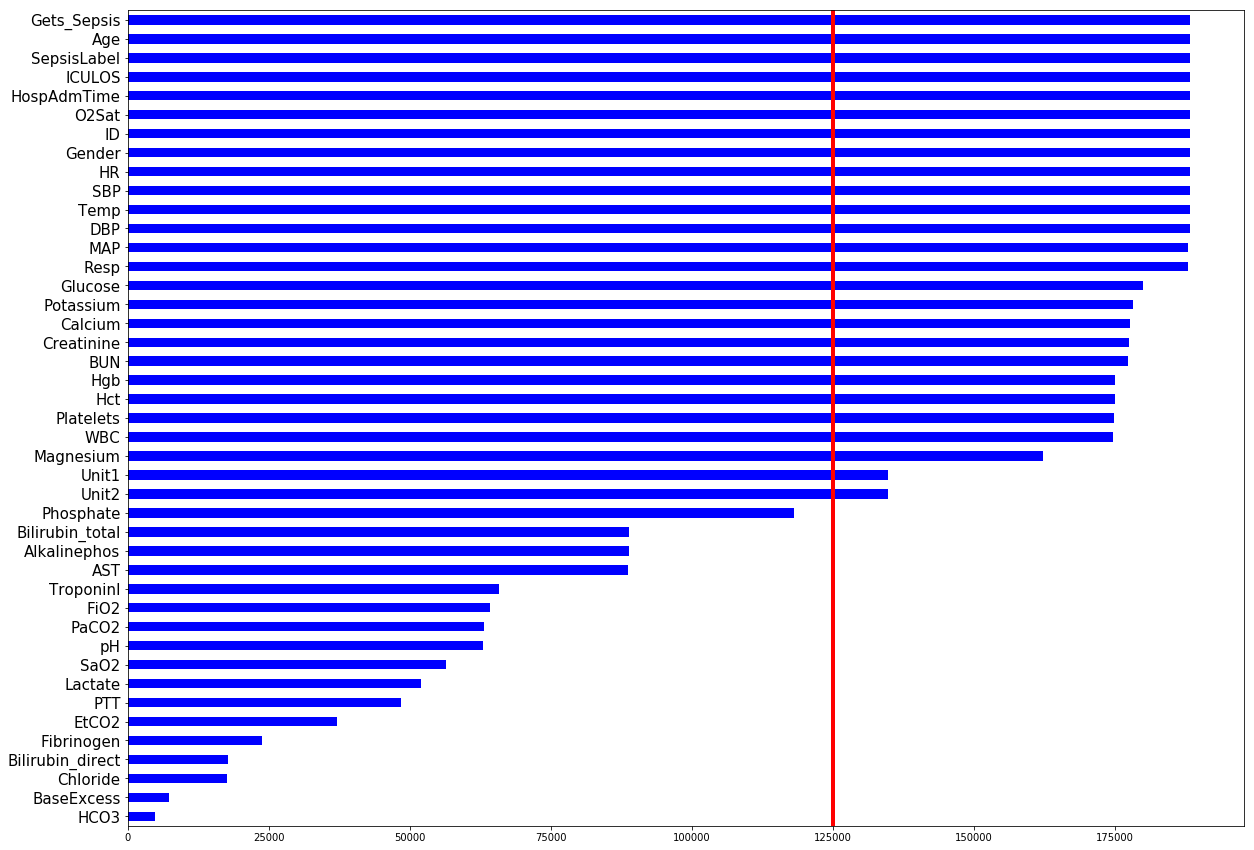

In [15]:
plt.figure(figsize=(20,15))
prelim_df.describe().loc['count'].sort_values().plot(kind = 'barh', color = 'b').tick_params(axis="y", labelsize=15);
plt.axvline(x=125000, linewidth=4, color = 'r');
locs, labels = plt.yticks() 

In [16]:
# Highest # of NaNs: 

HighNaNs = ['Phosphate', 'Bilirubin_total', 'Alkalinephos','AST', 'TroponinI','FiO2','PaCO2',
            'pH','SaO2','Lactate','PTT','EtCO2', 'Fibrinogen', 'Bilirubin_direct', 'Chloride','BaseExcess',
            'HCO3']



In [17]:
# Remove the columns with less than 125,000 NaNs

prelim_df2 = prelim_df.drop(HighNaNs, axis = 1)
prelim_df2.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
count,188439.000000,188453.000000,188350.000000,188363.000000,188007.000000,188302.000000,187969.000000,177444.000000,177687.000000,177483.000000,...,174882.000000,188453.000000,188453.000000,134782.000000,134782.000000,188453.000000,188453.000000,188453.000000,188453.000000,188453.000000
mean,83.824787,97.069290,36.796500,126.518417,86.749469,66.625170,18.642654,22.080203,7.817188,1.606027,...,201.296723,60.554085,0.541180,0.488352,0.511648,-65.130534,25.587913,0.013919,2500.664908,0.082376
std,17.551059,2.871161,0.599552,23.710338,16.300998,13.833184,4.490248,18.839560,2.408893,2.084873,...,100.389161,16.269188,0.498303,0.499866,0.499866,235.957301,27.142730,0.117153,1443.712885,0.274937
min,20.000000,20.000000,30.900000,20.000000,30.000000,20.000000,1.000000,1.000000,1.000000,0.200000,...,2.000000,16.000000,0.000000,0.000000,0.000000,-5366.860000,1.000000,0.000000,0.000000,0.000000
25%,71.000000,96.000000,36.442857,110.000000,75.096774,57.000000,16.000000,11.000000,7.800000,0.730000,...,137.000000,50.000000,0.000000,0.000000,0.000000,-56.580000,10.000000,0.000000,1242.000000,0.000000
50%,82.000000,97.500000,36.744444,124.000000,85.000000,65.000000,18.000000,16.000000,8.400000,0.950000,...,189.000000,62.000000,1.000000,0.000000,1.000000,-8.800000,20.000000,0.000000,2488.000000,0.000000
75%,95.000000,99.000000,37.110000,141.000000,96.000000,74.750000,21.000000,26.000000,8.800000,1.400000,...,249.000000,72.000000,1.000000,1.000000,1.000000,-3.160000,34.000000,0.000000,3753.000000,0.000000
max,194.000000,100.000000,42.100000,299.000000,296.000000,296.000000,100.000000,268.000000,27.900000,41.900000,...,2322.000000,101.000000,1.000000,1.000000,1.000000,0.000000,336.000000,1.000000,4999.000000,1.000000


In [18]:
clean2 = prelim_df2.dropna()

# Check how many patients we were able to preserve? How many rows?
print(clean2.ID.nunique())
print(clean2.shape)

2948
(117518, 26)


In [19]:
# Add the latent variables
# Shock index = HR/SBP
# O2 Delivery index = HR*(SBP-DBP)*Hgb*SPO2

clean2['ShockIndex'] = clean2['HR']/clean2['SBP']
clean2['O2DeliveryIndex'] = clean2['HR']*(clean2['SBP']-clean2['DBP'])*clean2['Hgb']*clean2['O2Sat']
clean2.head()

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis,ShockIndex,O2DeliveryIndex
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,1,0,0,0,0.787196,3.494429e+06
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,2,0,0,0,0.805825,3.660300e+06
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,3,0,0,0,0.776699,3.492720e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,4,0,0,0,0.813084,3.376296e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,5,0,0,0,0.858491,3.354952e+06


In [20]:
clean2.drop(['ShockIndex','O2DeliveryIndex'], axis = 1, inplace=True)
clean2.head()

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,125.0,54,1,1.0,0.0,-5.76,1,0,0,0
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,125.0,54,1,1.0,0.0,-5.76,2,0,0,0
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,125.0,54,1,1.0,0.0,-5.76,3,0,0,0
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,125.0,54,1,1.0,0.0,-5.76,4,0,0,0
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,125.0,54,1,1.0,0.0,-5.76,5,0,0,0


In [27]:
# Need to define model, param grid

def make_model(X, y, model, param_grid):
    
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X_IDs, y_outcomes):
        X_train3 = clean2.loc[clean2['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        X_test3 =  clean2.loc[clean2['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        y_train3 = clean2.loc[clean2['ID'].isin(list(train_index))]['Gets_Sepsis']
        y_test3 = clean2.loc[clean2['ID'].isin(list(test_index))]['Gets_Sepsis']
    

    # Instantiate the GridSearchCV object: logreg_cv
    model_cv = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

    # Fit it to the training data
    model_cv.fit(X_train3, y_train3)

    # Print the optimal parameters and best score
    print("Tuned Model Parameter: {}".format(model_cv.best_params_))
    print("Tuned AUROC {}".format(model_cv.best_score_))
    y_pred = model_cv.predict(X_test3)
    print(classification_report(y_test3, y_pred))
        

In [25]:
# Define the X and y

X_IDs = pd.Series(clean2['ID'].unique())
y_outcomes = clean2[['ID','Gets_Sepsis']].drop_duplicates().reset_index()['Gets_Sepsis']

In [28]:
# Setup for Logreg model
c_space = np.logspace(-10, 8, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the logistic regression classifier: logreg
logreg = LogisticRegression()

make_model(X_IDs,y_outcomes,logreg,param_grid=param_grid)

Tuned Model Parameter: {'C': 0.01, 'penalty': 'l2'}
Tuned AUROC 0.7419910596937985
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     13307
          1       0.83      0.17      0.29       999

avg / total       0.93      0.94      0.92     14306



In [29]:
# Set up param grid
param_grid = {'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}

# Instantiate the DT classifier: tree
tree = DecisionTreeClassifier()

make_model(X_IDs,y_outcomes,tree,param_grid=param_grid)

Tuned Model Parameter: {'max_depth': 19, 'min_samples_split': 490}
Tuned AUROC 0.7340452922973144
             precision    recall  f1-score   support

          0       0.95      0.98      0.96     13307
          1       0.47      0.29      0.36       999

avg / total       0.91      0.93      0.92     14306



In [30]:
N = [1,2,3,4,5,6,7,8,9,10]
param_grid = {'n_neighbors': N}

# Instantiate the kNN classifier: knn
knn = KNeighborsClassifier()

make_model(X_IDs, y_outcomes, knn, param_grid=param_grid)

Tuned Model Parameter: {'n_neighbors': 10}
Tuned AUROC 0.6296510768563239
             precision    recall  f1-score   support

          0       0.94      0.98      0.96     13307
          1       0.24      0.10      0.14       999

avg / total       0.89      0.92      0.90     14306



In [31]:
# Instantiate the RF classifier: forest
forest = RandomForestClassifier()

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

make_model(X_IDs, y_outcomes, forest, param_grid=param_grid)

Tuned Model Parameter: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 270}
Tuned AUROC 0.7723556088265632
             precision    recall  f1-score   support

          0       0.94      0.99      0.97     13307
          1       0.65      0.22      0.33       999

avg / total       0.92      0.94      0.92     14306



In [41]:
# Make a new function, make_scaled_model, that implements a StandardScaler step to the dataset

def make_scaled_model(X, y, model, param_grid):
    
    steps = [('scaler', StandardScaler()),
        ('model', model)]
    
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)
    
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X_IDs, y_outcomes):
        X_train3 = clean2.loc[clean2['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        X_test3 =  clean2.loc[clean2['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        y_train3 = clean2.loc[clean2['ID'].isin(list(train_index))]['Gets_Sepsis']
        y_test3 = clean2.loc[clean2['ID'].isin(list(test_index))]['Gets_Sepsis']
    
    # Instantiate the GridSearchCV object
    model_scaled = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

    # Fit the pipeline to the training set
    model_scaled.fit(X_train3, y_train3)

    # Print the optimal parameters and best score
    print("Tuned Scaled Model Parameter: {}".format(model_scaled.best_params_))
    print("Tuned Scaled Model ROC_AUC: {}".format(model_scaled.best_score_))
    y_pred = model_scaled.predict(X_test3)
    print(classification_report(y_test3, y_pred)) 

In [42]:
# KNN with StandardScaler
N = [5,6,7,8,9,10]
param_grid = {'model__n_neighbors': N}
knn = KNeighborsClassifier()

make_scaled_model(X_IDs, y_outcomes, knn, param_grid)

Tuned Scaled Model Parameter: {'model__n_neighbors': 10}
Tuned Scaled Model ROC_AUC: 0.630915494331331
             precision    recall  f1-score   support

          0       0.94      0.99      0.96     13307
          1       0.43      0.14      0.21       999

avg / total       0.90      0.93      0.91     14306



In [81]:
clean2.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis,ShockIndex,O2DeliveryIndex
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,1,0,0,0,0.787196,3.494429e+06
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,2,0,0,0,0.805825,3.660300e+06
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,3,0,0,0,0.776699,3.492720e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,4,0,0,0,0.813084,3.376296e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,5,0,0,0,0.858491,3.354952e+06


In [39]:
# Add the latent variables
# Shock index = HR/SBP
# O2 Delivery index = HR*(SBP-DBP)*Hgb*SPO2

clean2['ShockIndex'] = clean2['HR']/clean2['SBP']
clean2['O2DeliveryIndex'] = clean2['HR']*(clean2['SBP']-clean2['DBP'])*clean2['Hgb']*clean2['O2Sat']
clean2.head()

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,ID,Gets_Sepsis,ShockIndex,O2DeliveryIndex
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,1,0,0,0,0.787196,3.494429e+06
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,2,0,0,0,0.805825,3.660300e+06
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,3,0,0,0,0.776699,3.492720e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,4,0,0,0,0.813084,3.376296e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,1,1.0,0.0,-5.76,5,0,0,0,0.858491,3.354952e+06


In [121]:
# Add the trend features

features = list(clean2.columns)[:17]+['ShockIndex','O2DeliveryIndex']

for column in features:
    clean2[str(column)+'_lag'] = clean2[column].shift()
    clean2[str(column)+'_rolling'] = clean2[column].rolling(3).mean()
clean2.head()

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,Creatinine,...,Hgb_lag,Hgb_rolling,WBC_lag,WBC_rolling,Platelets_lag,Platelets_rolling,ShockIndex_lag,ShockIndex_rolling,O2DeliveryIndex_lag,O2DeliveryIndex_rolling
0,83.323529,98.205882,37.3,105.848485,71.515152,62.272727,13.931034,11.0,8.2,0.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,83.000000,100.000000,37.3,103.000000,68.000000,58.000000,13.931034,11.0,8.2,0.61,...,9.8,NaN,6.1,NaN,125.0,NaN,0.787196,NaN,3.494429e+06,NaN
2,80.000000,99.000000,36.7,103.000000,69.000000,58.000000,10.000000,11.0,8.2,0.61,...,9.8,9.8,6.1,6.1,125.0,125.0,0.805825,0.789907,3.660300e+06,3.549150e+06
3,87.000000,99.000000,37.3,107.000000,76.000000,67.000000,13.931034,11.0,8.2,0.61,...,9.8,9.8,6.1,6.1,125.0,125.0,0.776699,0.798536,3.492720e+06,3.509772e+06
4,91.000000,99.000000,37.3,106.000000,76.000000,68.000000,13.931034,11.0,8.2,0.61,...,9.8,9.8,6.1,6.1,125.0,125.0,0.813084,0.816091,3.376296e+06,3.407989e+06


In [122]:
clean2.dropna(inplace=True)

/Users/lucasfriedman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_IDs, y_outcomes):
    X_train3 = clean2.loc[clean2['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    X_test3 =  clean2.loc[clean2['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    y_train3 = clean2.loc[clean2['ID'].isin(list(train_index))]['Gets_Sepsis']
    y_test3 = clean2.loc[clean2['ID'].isin(list(test_index))]['Gets_Sepsis']

In [49]:
clean2_IDs = list(clean2['ID'].unique())

patients = []
for ID in clean2_IDs:
    patients.append(clean2[clean2['ID']==ID])

In [45]:
best_model = RandomForestClassifier(bootstrap=True, criterion='gini', 
                                    max_depth=None, max_features=10, min_samples_split=310)
best_model.fit(X_train3, y_train3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=310,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
# Going from timepoint predictions to patient predictions (FOCUS ON THIS ONE)

def predict_patient(model, patients):
    '''Takes in an entire patient file, predicts risk of Sepsis based on 
    timepoint, and infers whether the patient is at risk of getting Sepsis, based on
    multiple thresholds of positive timestamps'''
    

    # Establish the potential thresholds to iterate through
    pct_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    # Initiate lists for data viz
    accuracy_score_list = [] 
    precision_list = []
    recall_list = []
    f1_score_list = [] 
    
    for pct in pct_threshold: 
        # Initiate the parameter variables
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        accuracy = 0

        for patient in patients: 
            if 1 not in list(patient['SepsisLabel']):
                gets_sepsis = False
            else:
                gets_sepsis = True
            
            # Generate predictions per timepoint (rows) 
            X = patient.drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
            outcomes = model.predict(X)
            if sum(outcomes)/len(outcomes) >= pct:
                outcome = True
                if outcome == gets_sepsis:
                    tp += 1
                    accuracy += 1
                else:
                    fp += 1
            else:
                outcome = False
                if outcome == gets_sepsis:
                    tn += 1
                    accuracy += 1
                else:
                    fn += 1
                    
        accuracy_score = accuracy/len(patients)
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = 2*((precision*recall)/(precision+recall))
        
        accuracy_score_list.append(accuracy_score) 
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        
        print('Accuracy with positive threshold set at {}: {})'.format(pct, accuracy_score))
        print('Precision with positive threshold set at {}: {})'.format(pct, precision))
        print('Recall with positive threshold set at {}: {})'.format(pct, recall))
        print('F1-Score with positive threshold set at {}: {})'.format(pct, f1_score))
        print(" ")
    
    # set width of bar
    barWidth = 0.15
    
    # Make the grouped bar plot 
    # Set position of bar on X axis
    r1 = np.arange(len(accuracy_score_list))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    
    # Make the plot
    plt.figure(figsize=(20,10))
    plt.bar(r1, accuracy_score_list, color='blue', width=barWidth, edgecolor='white', label='Accuracy')
    plt.bar(r2, precision_list, color='orange', width=barWidth, edgecolor='white', label='Precision')
    plt.bar(r3, recall_list, color='green', width=barWidth, edgecolor='white', label='Recall')
    plt.bar(r4, f1_score_list, color='red', width=barWidth, edgecolor='white', label='F1')
 
    # Add xticks on the middle of the group bars
    plt.xlabel('% threshold', fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(accuracy_score_list))], pct_threshold)
 
    # Create legend & Show graphic
    plt.legend()
    plt.show()


Accuracy with positive threshold set at 0.1: 0.9596336499321574)
Precision with positive threshold set at 0.1: 0.691358024691358)
Recall with positive threshold set at 0.1: 0.37333333333333335)
F1-Score with positive threshold set at 0.1: 0.48484848484848486)
 
Accuracy with positive threshold set at 0.2: 0.9596336499321574)
Precision with positive threshold set at 0.2: 0.7246376811594203)
Recall with positive threshold set at 0.2: 0.3333333333333333)
F1-Score with positive threshold set at 0.2: 0.45662100456621)
 
Accuracy with positive threshold set at 0.3: 0.9603120759837178)
Precision with positive threshold set at 0.3: 0.7619047619047619)
Recall with positive threshold set at 0.3: 0.32)
F1-Score with positive threshold set at 0.3: 0.4507042253521127)
 
Accuracy with positive threshold set at 0.4: 0.9599728629579376)
Precision with positive threshold set at 0.4: 0.7962962962962963)
Recall with positive threshold set at 0.4: 0.2866666666666667)
F1-Score with positive threshold set a

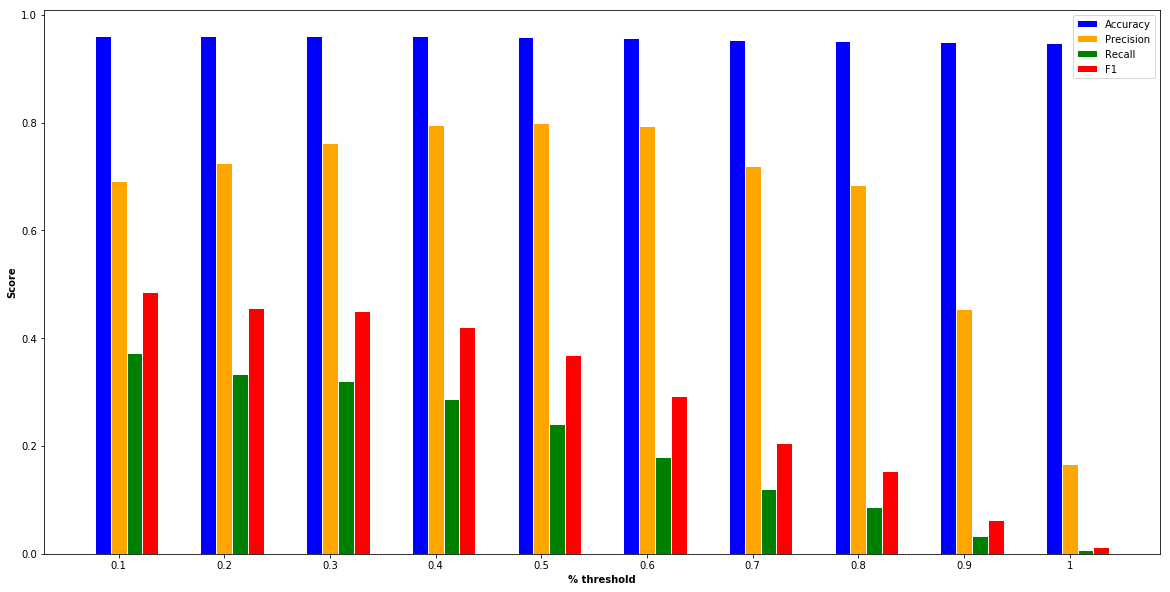

In [131]:
predict_patient(best_model, patients)

In [78]:
def make_roc_curve(model, patients):

    sepsis_status = []
    df_roc = pd.DataFrame()
    
    
    # Make the sepsis_status column
    for patient in patients: 
        if 1 not in list(patient['SepsisLabel']):
            gets_sepsis = 0
        else:
            gets_sepsis = 1
        sepsis_status.append(gets_sepsis)
        
    df_roc['Sepsis_status'] = sepsis_status
    
    # Make the sepsis score column   
    sepsis_score = []
    for patient in patients:
        # Generate predictions per timepoint (rows) 
        X = patient.drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
        outcomes = model.predict(X)
        ratio = sum(outcomes)/len(outcomes)            
        sepsis_score.append(ratio)
        
    df_roc['Sepsis_score'] = sepsis_score
    fpr, tpr, _ = roc_curve(df_roc['Sepsis_status'], df_roc['Sepsis_score'])
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
            

In [79]:
make_roc_curve(best_model, patients)

0.741819156540386


In [ ]:
# Going from timepoint predictions to patient predictions

def predict_patient(model, patients):
    '''Takes in an entire patient file, predicts risk of Sepsis based on 
    timepoint, and infers whether the patient is at risk of getting Sepsis, based on
    multiple thresholds of positive timestamps'''
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    accuracy = 0
    
    #VS_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']
    #LV_features = ['BUN', 'Calcium', 'Creatinine', 'Glucose', 'Magnesium',
    #           'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age', 'Gender', 
    #           'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 
    #           'Gets_Sepsis', 'ShockIndex', 'O2DeliveryIndex']
    #HighNaNs = ['Phosphate', 'Bilirubin_total', 'Alkalinephos','AST', 'TroponinI','FiO2','PaCO2',
    #        'pH','SaO2','Lactate','PTT','EtCO2', 'Fibrinogen', 'Bilirubin_direct', 'Chloride','BaseExcess',
    #        'HCO3']
    
    

    # Establish the potential thresholds to iterate through
    pct_threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    for pct in pct_threshold: 
        for patient in patients:
        
            # Clean and format data that the model can fit in
            #patient.drop(HighNaNs, axis = 1, inplace=True)
            
            # Filling NaN values for remaining VS features with mean
            # for feature in VS_features:
            #    patient[feature].fillna((patient[feature].mean()), inplace = True)
                
            # Filling NaN values for remaining LV features with ffill/bfill
            #patient[LV_features] = patient[LV_features].fillna(method='ffill')
            #patient[LV_features] = patient[LV_features].fillna(method='bfill')
            
            # Add the latent variables
            # Shock index = HR/SBP
            # O2 Delivery index = HR*(SBP-DBP)*Hgb*SPO2

            #patient['ShockIndex'] = patient['HR']/patient['SBP']
            #patient['O2DeliveryIndex'] = patient['HR']*(patient['SBP']-patient['DBP'])*patient['Hgb']*patient['O2Sat']

            if 1 not in list(patient['SepsisLabel']):
                gets_sepsis = False
            else:
                gets_sepsis = True
            
            # Generate predictions per timepoint (rows)
            X = patient.drop('SepsisLabel', axis = 1)
            outcomes = list(model.predict(X))
            if sum(outcomes)/len(outcomes) >= pct:
                outcome = True
                if outcome == gets_sepsis:
                    tp += 1
                    accuracy += 1
                else:
                    fp += 1
            else:
                outcome = False
                if outcome == gets_sepsis:
                    tn += 1
                    accuracy += 1
                else:
                    fn += 1
                    
        accuracy_score = accuracy/patients 
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        f1_score = 2*((precision*recall)/(precision+recall))
    
        print('Accuracy with positive threshold set at {}: {})'.format(pct_threshold,accuracy_score))
        print('Precision with positive threshold set at {}: {})'.format(pct_threshold,precision))
        print('Recall with positive threshold set at {}: {})'.format(pct_threshold,recall))
        print('F1-Score with positive threshold set at {}: {})'.format(pct_threshold,f1_score))

In [84]:
# Simple RandomForestClassifier with GridSearch for optimal hyperparameters
# This model includes the 2 latent features


# Instantiate the RF classifier: tree

forest = RandomForestClassifier()

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Create train and test sets
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_IDs, y_outcomes):
    X_train3 = clean2.loc[clean2['ID'].isin(list(train_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    X_test3 =  clean2.loc[clean2['ID'].isin(list(test_index))].drop(['SepsisLabel','ID','Gets_Sepsis'], axis = 1)
    y_train3 = clean2.loc[clean2['ID'].isin(list(train_index))]['Gets_Sepsis']
    y_test3 = clean2.loc[clean2['ID'].isin(list(test_index))]['Gets_Sepsis']

# Instantiate the GridSearchCV object: knn_cv

# Fit it to the training data
forest_cv.fit(X_train3, y_train3)

# Predict the labels of the test set: y_pred
y_pred = forest_cv.predict(X_test3)

# Print the optimal parameters and best score
print("Tuned Parameters: {}".format(forest_cv.best_params_))
print("Tuned ROC_AUC: {}".format(forest_cv.best_score_))
print(classification_report(y_test3, y_pred))

Tuned Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 310}
Tuned ROC_AUC: 0.7808038001992643
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     13307
          1       0.76      0.25      0.38       999

avg / total       0.93      0.94      0.93     14306



In [85]:
clean2.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BUN', 'Calcium',
       'Creatinine', 'Glucose', 'Magnesium', 'Potassium', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS',
       'SepsisLabel', 'ID', 'Gets_Sepsis', 'ShockIndex', 'O2DeliveryIndex'],
      dtype='object')

In [ ]:
# https://tbiomed.biomedcentral.com/articles/10.1186/1742-4682-8-40
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6299613/pdf/13054_2018_Article_2279.pdf

# Standardize Candidate Feature Formatting
# There are fixed intervals (vital signs like HR and temp), and non-standard intervals (platelets and WBC)

# Vital signs (columns 1-8) -> Time Series features 
# Laboratory values (columns 9-34) -> Multivariate features 
# Personal info (columns 35-40) -> Demographic features

# Time Series
# Fill NaN values with mean values 


# Notes:
# Deal with the imbalance
# create a was_analyzed features
# a lag

# Notes: 
# Systolic should always be greater than diastolic by definition. 

# 'HR'
# 'O2Sat'
# 'Temp',
# 'SBP',
# 'MAP',
# 'DBP',
# 'Resp',
# 'EtCO2',

# Multivariate features 
# Literature says to use the most recent multivariate features before onset of sepsis, but there are some values where
# I may want to forward/backward fill

 'BaseExcess',
 'HCO3',
 'FiO2',
 'pH',
 'PaCO2',
 'SaO2',
 'AST',
 'BUN',
 'Alkalinephos',
 'Calcium',
 'Chloride',
 'Creatinine',
 'Bilirubin_direct',
 'Glucose',
 'Lactate',
 'Magnesium',
 'Phosphate',
 'Potassium',
 'Bilirubin_total',
 'TroponinI',
 'Hct',
 'Hgb',
 'PTT',
 'WBC',
 'Fibrinogen',
 'Platelets',


# Demographic features

# 'Age' -> One value
# 'Gender', -> One value 
# 'Unit1', -> I say ignore
# 'Unit2', -> I say ignore
# 'HospAdmTime', -> I say ignore 
# 'ICULOS', -> Must be useful somewhere


# Clinical latent features (can be treated like time series)

# Shock index = HR/SBP
# O2 Delivery index = HR*(SBP-DBP)*Hgb*SPO2

# Trend features of time series
# Max, min, mean, mode, median, slope, intercept

# Predictor variable

# SepsisLabel

In [ ]:
#!/usr/bin/env python3

import sys
import numpy as np


def get_sepsis_score(values, column_names):
    x_mean = np.array([
        83.8996, 97.0520,  36.8055,  126.2240, 86.2907,
        66.2070, 18.7280,  33.7373,  -3.1923,  22.5352,
        0.4597,  7.3889,   39.5049,  96.8883,  103.4265,
        22.4952, 87.5214,  7.7210,   106.1982, 1.5961,
        0.6943,  131.5327, 2.0262,   2.0509,   3.5130,
        4.0541,  1.3423,   5.2734,   32.1134,  10.5383,
        38.9974, 10.5585,  286.5404, 198.6777])
    x_std = np.array([
        17.6494, 3.0163,  0.6895,   24.2988, 16.6459,
        14.0771, 4.7035,  11.0158,  3.7845,  3.1567,
        6.2684,  0.0710,  9.1087,   3.3971,  430.3638,
        19.0690, 81.7152, 2.3992,   4.9761,  2.0648,
        1.9926,  45.4816, 1.6008,   0.3793,  1.3092,
        0.5844,  2.5511,  20.4142,  6.4362,  2.2302,
        29.8928, 7.0606,  137.3886, 96.8997])
    c_mean = np.array([60.8711, 0.5435, 0.0615, 0.0727, -59.6769, 28.4551])
    c_std = np.array([16.1887, 0.4981, 0.7968, 0.8029, 160.8846, 29.5367])

    x = values[:, 0:34]
    c = values[:, 34:40]
    x_norm = np.nan_to_num((x - x_mean) / x_std)
    c_norm = np.nan_to_num((c - c_mean) / c_std)

    beta = np.array([
        0.1806,  0.0249, 0.2120,  -0.0495, 0.0084,
        -0.0980, 0.0774, -0.0350, -0.0948, 0.1169,
        0.7476,  0.0323, 0.0305,  -0.0251, 0.0330,
        0.1424,  0.0324, -0.1450, -0.0594, 0.0085,
        -0.0501, 0.0265, 0.0794,  -0.0107, 0.0225,
        0.0040,  0.0799, -0.0287, 0.0531,  -0.0728,
        0.0243,  0.1017, 0.0662,  -0.0074, 0.0281,
        0.0078,  0.0593, -0.2046, -0.0167, 0.1239])
    rho = 7.8521
    nu = 1.0389

    xstar = np.concatenate((x_norm, c_norm), axis=1)
    exp_bx = np.exp(np.matmul(xstar, beta))
    l_exp_bx = pow(4 / rho, nu) * exp_bx

    scores = 1 - np.exp(-l_exp_bx)
    labels = (scores > 0.45)
    return (scores, labels)


def read_challenge_data(input_file):
    with open(input_file, 'r') as f:
        header = f.readline().strip()
        column_names = header.split('|')
        values = np.loadtxt(f, delimiter='|')
    # ignore SepsisLabel column if present
    if column_names[-1] == 'SepsisLabel':
        column_names = column_names[:-1]
        values = values[:, :-1]
    return (values, column_names)


if __name__ == '__main__':
    if len(sys.argv) != 2:
        sys.exit('Usage: %s input[.psv]' % sys.argv[0])

    record_name = sys.argv[1]
    if record_name.endswith('.psv'):
        record_name = record_name[:-4]

    # read input data
    input_file = record_name + '.psv'
    (values, column_names) = read_challenge_data(input_file)

    # generate predictions
    (scores, labels) = get_sepsis_score(values, column_names)

    # write predictions to output file
    output_file = record_name + '.out'
    with open(output_file, 'w') as f:
        for (s, l) in zip(scores, labels):
            f.write('%g|%d\n' % (s, l))

In [ ]:
# This file contains functions for computing scores for the 2019 PhysioNet/CinC
# challenge.
#
# Written by M. Reyna on 1 February 2019.  Last updated on 18 February 2019.
#
# The compute_scores_2019 function computes a normalized utility score for a
# cohort of patients as well as several traditional scoring metrics.
#
# Inputs:
#   'labels_directory' is a directory of pipe-delimited text files containing a
#   binary vector of labels indicating whether a patient is not septic (0) or
#   septic (1).
#
#   'predictions_directory' is a directory of pipe-delimited text files, where
#   the first column of the file gives the  predicted probability that the
#   patient is septic at each time, and the second column of the file is a
#   binarized version of this vector. Note that there must be a prediction for
#   every label.
#
#   Note: Currently, filenames in labels_directory and predictions_directory
#   must be the same, and the extension must be .psv.
#
# Output:
#   'output_file' is a pipe-delimited text file (optional) that gives AUROC,
#   AUPRC, accuracy, F-measure, and utility scores for a cohort of patients.
#
# Example:
#
#   In [1]: compute_scores_2019('labels', 'predictions')
#   Out[1]: auroc, auprc, accuracy, f_measure, utility

import numpy as np, os, os.path, sys, argparse
from collections import defaultdict

def compute_scores_2019(label_directory, prediction_directory):
    # Set parameters.
    label_header       = 'SepsisLabel'
    prediction_header  = 'PredictedLabel'
    probability_header = 'PredictedProbability'

    dt_early   = -12
    dt_optimal = -6
    dt_late    = 3

    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0

    # Find label and prediction files.
    label_files = []
    for filename in os.listdir(label_directory):
        full_filename = os.path.join(label_directory, filename)
        if os.path.isfile(full_filename) and full_filename.endswith('.psv'):
            label_files.append(filename)
    label_files = sorted(label_files)

    prediction_files = []
    for filename in os.listdir(prediction_directory):
        full_filename = os.path.join(prediction_directory, filename)
        if os.path.isfile(full_filename) and full_filename.endswith('.psv'):
            prediction_files.append(filename)
    prediction_files = sorted(prediction_files)

    if len(label_files) != len(prediction_files):
        raise Exception('Numbers of labels and predictions must be the same.')

    # Load labels and predictions.
    num_files            = len(label_files)
    cohort_labels        = []
    cohort_predictions   = []
    cohort_probabilities = []

    for k in range(num_files):
        labels        = load_column(os.path.join(label_directory, label_files[k]), label_header)
        predictions   = load_column(os.path.join(prediction_directory, prediction_files[k]), prediction_header)
        probabilities = load_column(os.path.join(prediction_directory, prediction_files[k]), probability_header)

        # Check labels and predictions for errors.
        if not (len(labels) == len(predictions) and len(predictions) == len(probabilities)):
            raise Exception('Numbers of labels and predictions must be the same.')

        num_records = len(labels)

        for i in range(num_records):
            if labels[i] not in (0, 1):
                raise Exception('Labels must satisfy label == 0 or label == 1.')

            if predictions[i] not in (0, 1):
                raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

            if not 0 <= probabilities[i] <= 1:
                raise Exception('Probabilities must satisfy 0 <= probability <= 1.')

        if 0<np.sum(predictions)<num_records:
            min_probability_positive = np.min(probabilities[predictions == 1])
            max_probability_negative = np.max(probabilities[predictions == 0])

            if min_probability_positive <= max_probability_negative:
                raise Exception('Predictions are inconsistent with probabilities, i.e., a positive prediction has a lower (or equal) probability than a negative prediction.')

        # Record labels and predictions.
        cohort_labels.append(labels)
        cohort_predictions.append(predictions)
        cohort_probabilities.append(probabilities)

    # Compute AUC, accuracy, and F-measure.
    labels        = np.concatenate(cohort_labels)
    predictions   = np.concatenate(cohort_predictions)
    probabilities = np.concatenate(cohort_probabilities)

    auroc, auprc        = compute_auc(labels, probabilities)
    accuracy, f_measure = compute_accuracy_f_measure(labels, predictions)

    # Compute utility.
    observed_utilities = np.zeros(num_files)
    best_utilities     = np.zeros(num_files)
    worst_utilities    = np.zeros(num_files)
    inaction_utilities = np.zeros(num_files)

    for k in range(num_files):
        labels = cohort_labels[k]
        num_records          = len(labels)
        observed_predictions = cohort_predictions[k]
        best_predictions     = np.zeros(num_records)
        worst_predictions    = np.zeros(num_records)
        inaction_predictions = np.zeros(num_records)

        if any(labels):
            t_sepsis = min(i for i, label in enumerate(labels) if label) - dt_optimal
            best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late, num_records)] = 1
        else:
            best_predictions[:] = 0
        worst_predictions = 1 - best_predictions

        observed_utilities[k] = compute_prediction_utility(labels, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        best_utilities[k]     = compute_prediction_utility(labels, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        worst_utilities[k]    = compute_prediction_utility(labels, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
        inaction_utilities[k] = compute_prediction_utility(labels, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    unnormalized_observed_utility = np.sum(observed_utilities)
    unnormalized_best_utility     = np.sum(best_utilities)
    unnormalized_worst_utility    = np.sum(worst_utilities)
    unnormalized_inaction_utility = np.sum(inaction_utilities)

    if not (unnormalized_worst_utility <= unnormalized_best_utility and unnormalized_inaction_utility <= unnormalized_best_utility):
        raise Exception('Optimal utility must be higher than inaction utility.')

    normalized_observed_utility = (unnormalized_observed_utility - unnormalized_inaction_utility) / (unnormalized_best_utility - unnormalized_inaction_utility)

    return auroc, auprc, accuracy, f_measure, normalized_observed_utility

# The load_column function loads a column from a table.
#
# Inputs:
#   'filename' is a string containing a filename.
#
#   'header' is a string containing a header.
#
# Outputs:
#   'column' is a vector containing a column from the file with the given
#   header.
#
# Example:
#
#   Omitted.

def load_column(filename, *headers):
    header_to_index = defaultdict(list)
    header_to_column = defaultdict(list)
    with open(filename, 'r') as f:
        for i, l in enumerate(f):
            arrs = l.strip().split('|')
            if i == 0:
                for header in headers:
                    try:
                        header_to_index[header] = arrs.index(header)
                    except:
                        raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
            else:
                for header in headers:
                    try:
                        header_to_column[header].append(float(arrs[header_to_index[header]]))
                    except:
                        raise Exception('{} must contain column with header {} containing numerical entries.'.format(filename, header))
    columns = [np.array(header_to_column[header]) for header in headers]

    if len(headers) == 1:
        return columns[0]
    else:
        return columns

# The compute_auc function computes AUROC and AUPRC as well as other summary
# statistics (TP, FP, FN, TN, TPR, TNR, PPV, NPV, etc.) that can be exposed
# from this function.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a probability vector, where predictions[i] gives the
#   predicted probability that the patient is septic at time i.  Note that there
#   must be a prediction for every label, i.e, len(labels) ==
#   len(predictions).
#
# Outputs:
#   'auroc' is a scalar that gives the AUROC of the classifier using its
#   predicted probabilities, where specificity is interpolated for intermediate
#   sensitivity values.
#
#   'auprc' is a scalar that gives the AUPRC of the classifier using its
#   predicted probabilities, where precision is a piecewise constant function of
#   recall.
#
# Example:
#
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0.3, 0.4, 0.6, 0.7, 0.8, 0.8]
#   In [3]: auroc, auprc = compute_auc(labels, predictions)
#   In [4]: auroc
#   Out[4]: 1.0
#   In [5]: auprc
#   Out[5]: 1.0

def compute_auc(labels, predictions):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not 0 <= predictions[i] <= 1:
            raise Exception('Predictions must satisfy 0 <= prediction <= 1.')

    # Find prediction thresholds.
    thresholds = np.unique(predictions)[::-1]
    if thresholds[0] != 1:
        thresholds = np.concatenate((np.array([1]), thresholds))

    if thresholds[-1] != 0:
        thresholds = np.concatenate((thresholds, np.array([0])))
    m = len(thresholds)

    # Populate contingency table across prediction thresholds.
    tp = np.zeros(m)
    fp = np.zeros(m)
    fn = np.zeros(m)
    tn = np.zeros(m)

    # Find indices that sort predicted probabilities from largest to smallest.
    idx = np.argsort(predictions)[::-1]

    i = 0
    for j in range(m):
        # Initialize contingency table for j-th prediction threshold.
        if j == 0:
            tp[j] = 0
            fp[j] = 0
            fn[j] = np.sum(labels == 1)
            tn[j] = np.sum(labels == 0)
        else:
            tp[j] = tp[j - 1]
            fp[j] = fp[j - 1]
            fn[j] = fn[j - 1]
            tn[j] = tn[j - 1]

        # Update contingency table for i-th largest prediction probability.
        while i < n and predictions[idx[i]] >= thresholds[j]:
            if labels[idx[i]]:
                tp[j] += 1
                fn[j] -= 1
            else:
                fp[j] += 1
                tn[j] -= 1
            i += 1

    # Summarize contingency table.
    tpr = np.zeros(m)
    tnr = np.zeros(m)
    ppv = np.zeros(m)
    npv = np.zeros(m)

    for j in range(m):
        if tp[j] + fn[j]:
            tpr[j] = tp[j] / (tp[j] + fn[j])
        else:
            tpr[j] = 1
        if fp[j] + tn[j]:
            tnr[j] = tn[j] / (fp[j] + tn[j])
        else:
            tnr[j] = 1
        if tp[j] + fp[j]:
            ppv[j] = tp[j] / (tp[j] + fp[j])
        else:
            ppv[j] = 1
        if fn[j] + tn[j]:
            npv[j] = tn[j] / (fn[j] + tn[j])
        else:
            npv[j] = 1

    # Compute AUROC as the area under a piecewise linear function of TPR /
    # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
    # under a piecewise constant of TPR / recall (x-axis) and PPV / precision
    # (y-axis).
    auroc = 0
    auprc = 0
    for j in range(m-1):
        auroc += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
        auprc += (tpr[j + 1] - tpr[j]) * ppv[j + 1]

    return auroc, auprc

# The compute_accuracy_f_measure function computes the accuracy and F-measure
# for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'accuracy' is a scalar that gives the accuracy of the classifier using its
#   binarized predictions.
#
#   'f_measure' is a scalar that gives the F-measure of the classifier using its
#   binarized predictions.
#
# Example:
#   In [1]: labels = [0, 0, 0, 0, 1, 1]
#   In [2]: predictions = [0, 0, 1, 1, 1, 1]
#   In [3]: accuracy, f_measure = compute_prediction_utility(labels, predictions)
#   In [4]: accuracy
#   Out[4]: 0.666666666667
#   In [5]: f_measure
#   Out[5]: 0.666666666667

def compute_accuracy_f_measure(labels, predictions):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not predictions[i] in (0, 1):
            raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    # Populate contingency table.
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(n):
        if labels[i] and predictions[i]:
            tp += 1
        elif labels[i] and not predictions[i]:
            fp += 1
        elif not labels[i] and predictions[i]:
            fn += 1
        elif not labels[i] and not predictions[i]:
            tn += 1

    # Summarize contingency table.
    if tp + fp + fn + tn:
        accuracy = float(tp + tn) / float(tp + fp + fn + tn)
    else:
        accuracy = 1.0

    if 2 * tp + fp + fn:
        f_measure = float(2 * tp) / float(2 * tp + fp + fn)
    else:
        f_measure = 1.0

    return accuracy, f_measure

# The compute_prediction_utility function computes the total time-dependent
# utility for a patient.
#
# Inputs:
#   'labels' is a binary vector, where labels[i] == 0 if the patient is not
#   labeled as septic at time i and labels[i] == 1 if the patient is labeled as
#   septic at time i.
#
#   'predictions' is a binary vector, where predictions[i] == 0 if the patient
#   is not predicted to be septic at time i and predictions[i] == 1 if the
#   patient is predicted to be septic at time i.  Note that there must be a
#   prediction for every label, i.e, len(labels) == len(predictions).
#
# Output:
#   'utility' is a scalar that gives the total time-dependent utility of the
#   classifier using its binarized predictions.
#
# Example:
#   In [1]: labels = [0 0 0 0 1 1]
#   In [2]: predictions = [0 0 1 1 1 1]
#   In [3]: utility = compute_prediction_utility(labels, predictions)
#   In [4]: utility
#   Out[4]: 0.444444444444

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0):
    # Check inputs for errors.
    if len(predictions) != len(labels):
        raise Exception('Numbers of predictions and labels must be the same.')

    n = len(labels)
    for i in range(n):
        if not labels[i] in (0, 1):
            raise Exception('Labels must satisfy label == 0 or label == 1.')

    for i in range(n):
        if not predictions[i] in (0, 1):
            raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

    if dt_early >= dt_optimal:
        raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

    if dt_optimal >= dt_late:
        raise Exception('The optimal time for predictions must be before the latest beneficial time.')

    # Does the patient eventually have sepsis?
    if any(labels):
        is_septic = True
        t_sepsis = min(i for i, label in enumerate(labels) if label) - dt_optimal
    else:
        is_septic = False
        t_sepsis = float('inf')

    # Define slopes and intercept points for affine utility functions of the
    # form u = m * t + b.
    m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
    b_1 = -m_1 * dt_early
    m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
    b_2 = -m_2 * dt_late
    m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
    b_3 = -m_3 * dt_optimal

    # Compare predicted and true conditions.
    u = np.zeros(n)
    for t in range(n):
        if t <= t_sepsis + dt_late:
            # TP
            if is_septic and predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                elif t <= t_sepsis + dt_late:
                    u[t] = m_2 * (t - t_sepsis) + b_2
            # FN
            elif is_septic and not predictions[t]:
                if t <= t_sepsis + dt_optimal:
                    u[t] = 0
                elif t <= t_sepsis + dt_late:
                    u[t] = m_3 * (t - t_sepsis) + b_3
            # FP
            elif not is_septic and predictions[t]:
                u[t] = u_fp
            # TN
            elif not is_septic and not predictions[t]:
                u[t] = u_tn

    # Find total utility for patient.
    return np.sum(u)

def get_parser():
    parser = argparse.ArgumentParser(description = 'Evaluate classifiers for cohort.')
    parser.add_argument('-l', '--labels_directory',      type=str, required=True,  help='Labels directory')
    parser.add_argument('-p', '--predictions_directory', type=str, required=True,  help='Predictions directory')
    parser.add_argument('-o', '--output_file',           type=str, required=False, help='Output filename')
    return parser

def run(args):
    auroc, auprc, accuracy, f_measure, utility = compute_scores_2019(args.labels_directory, args.predictions_directory)

    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Utility\n{}|{}|{}|{}|{}'.format(auroc, auprc, accuracy, f_measure, utility)

    if args.output_file:
        with open(args.output_file, 'w') as f:
            f.write(output_string)
    else:
        print(output_string)

if __name__=='__main__':
    run(get_parser().parse_args(sys.argv[1:]))
    

    